In [27]:
import itertools
import sys

import matplotlib.pyplot as plt

sys.path.append('..')
from antlia import lidar
from antlia import util

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [28]:
def set_title(ax, title):
    try:
        mpld3
    except NameError:
        ax.figure.suptitle(title)
    else:
        ax.set_title(title)
        
DEFAULT_FIGSIZE = (14, 7)

In [29]:
records = lidar.load_records(sync=True)

Unable to determine range 2
Unable to determine range 1


In [30]:
import numpy as np

def lidar_frame_index(record, time):
    """Get lidar frames at time.
    
    Parameters:
    time:, float or indexing function 
    """
    if not callable(time):
        return  np.where(record.lidar.time >= time)[0][0]
    
    return np.where(time(record.lidar.time))[0]
    
print(lidar_frame_index(records[0], 3))
print(lidar_frame_index(records[0], lambda t: (t >= 3) &(t < 4)))

60
[60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]


In [31]:
def lidar_frame(record, time):
    index = lidar_frame_index(record, time)
    return record.lidar[index]
    
def get_lidar_cartesian(frame, xlim=None, ylim=None):
    rho = frame.distance
    x = rho*np.cos(lidar.LIDAR_ANGLES)
    y = rho*np.sin(lidar.LIDAR_ANGLES)
    
    idx = np.zeros(x.shape, dtype=bool)
    if xlim is not None:
        xmin, xmax = xlim
        idx = idx | (x < xmin) | (x > xmax)
    if ylim is not None:
        ymin, ymax = ylim
        idx = idx | (y < ymin) | (y > ymax)
    return (np.ma.masked_array(x, idx),
            np.ma.masked_array(y, idx))

frames = lidar_frame(records[0], lambda t: (t >= 3) & (t < 4))
print(frames.distance)

x, y = get_lidar_cartesian(frames, xlim=(-50, 50), ylim=(-1, 9))
print('x', x)
print('y', y)
print(x.shape)
print(y.shape)


[[   1.131    1.131    1.101 ...,  120.     120.     120.   ]
 [   1.105    1.103    1.103 ...,  120.     120.     120.   ]
 [   1.097    1.099    1.103 ...,  120.     120.     120.   ]
 ..., 
 [   1.092    1.078    1.092 ...,  120.     120.     120.   ]
 [   1.091    1.091    1.093 ...,  120.     120.     120.   ]
 [   1.079    1.086    1.086 ...,  120.     120.     120.   ]]
x [[1.1266962035417643 1.126908575275916 1.0972186182500354 ..., -- -- --]
 [1.1007951413913788 1.099009866073683 1.0992117492550308 ..., -- -- --]
 [1.0928255838066447 1.0950243361876495 1.0992117492550308 ..., -- -- --]
 ..., 
 [1.0878446103161863 1.074100304285975 1.0882495287275555 ..., -- -- --]
 [1.0868484156180944 1.087053276415583 1.0892460942300533 ..., -- -- --]
 [1.0748940792409933 1.0820713640580415 1.082270135712569 ..., -- -- --]]
y [[-0.09857314504760138 -0.09611484260823151 -0.09117183647093696 ..., -- --
  --]
 [-0.09630709573616227 -0.09373534164180314 -0.09133745288596137 ..., -- --
  --]
 [-0.

In [46]:
records[0].lidar.distance[3, :].shape

(1521,)

In [62]:
%matplotlib inline

rider 3, trial 05, 593.691	593.700	0.009
rider 3, trial 06, 688.094	688.100	0.006


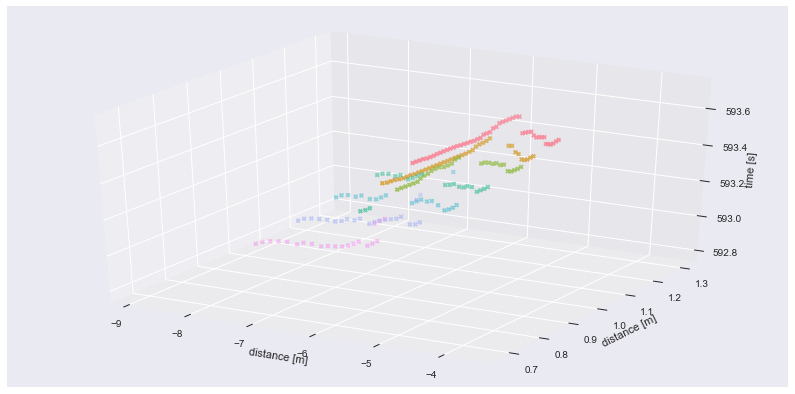

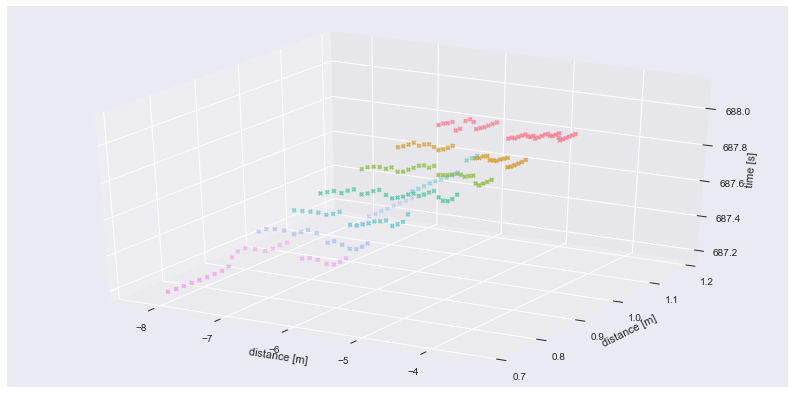

In [43]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

plt.close()
for rid, tid in itertools.product(range(3, 4), range(5, 7)):
    record = records[rid]
    trial = record.trial[tid]
    
    ev_time, ev_steer, ev = trial.steer_event_parameters()
    
    index0 = lidar_frame_index(record, ev_time[0])
    index = range(index0, index0 - 20, -3)
    
    xlim = (-15, -1)
    ylim = (-1, 3)
    x, y = get_lidar_cartesian(
        record.lidar[index],
        xlim=xlim,
        ylim=ylim)
    
    ## 3d plot
    z = np.concatenate(
        [t*np.ones(n) for t, n in zip(record.lidar[index].time,
                                      x.count(axis=1))])
    
    colors = sns.husl_palette(len(index), l=0.7)
    c = np.vstack(np.tile(colors[i], (n, 1))
                  for i, n in enumerate(x.count(axis=1)))
    
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE,
                           subplot_kw={'projection': '3d'})
    ax.scatter(x.compressed(), y.compressed(), z, c=c, marker='X')
    ax.set_xlabel('distance [m]')
    ax.set_ylabel('distance [m]')
    ax.set_zlabel('time [s]')
 
    ## 2d plot
    #fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    #colors = sns.husl_palette(len(index), l=0.7)
    #for i in range(len(index)):
    #    ax.plot(x[i, :], y[i, :], 'X',
    #            color=colors[i],
    #            label='frame {:0.03f} s'.format(record.lidar[index[i]].time))
    #ax.legend()
    #ax.set_xlabel('distance [m]')
    #ax.set_ylabel('distance [m]')
    #ax.set_title('LIDAR frame at time {:0.03f} (x:{}, y:{})'.format(
    #    record.lidar[index0].time, xlim, ylim))

    print('rider {}, trial {:02d}, {:0.03f}\t{:0.03f}\t{:0.03f}'.format(
        rid, tid, ev_time[0], record.lidar[index0].time,
        record.lidar[index0].time - ev_time[0]))
    
plt.show()

In [69]:
import matplotlib.animation

def animate_lidar_samples(lidar_record, xlim=None, ylim=None, speedup=1, **kwargs):
    fig, ax = plt.subplots(**kwargs)
    
    line, = ax.plot([], [], 'X', animated=True)
    ax.set_xlabel('x coordinate [meters]')
    ax.set_ylabel('y coordinate [meters]')
    
    def init():
        #ax.set_aspect('equal')
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        line.set_data([], [])
        return line,
    
    def update(i):
        x, y = get_lidar_cartesian(lidar_record[i],
                                   xlim=xlim, ylim=ylim)
        line.set_data(x, y)
        return line,
        
    t = lidar_record.time
    dt = np.diff(t)
    
    animator = matplotlib.animation.FuncAnimation(
        fig,
        update,
        frames=len(lidar_record),
        init_func=init,
        interval=int(dt.mean() * 1000 * 1/speedup),
        blit=True)
    
    return animator

In [74]:
import IPython.display

ev_time, _, _ = records[3].trial[5].steer_event_parameters()
t0 = ev_time[0] - 1
t1 = ev_time[-1] + 1
frames = lidar_frame(records[3],
                     lambda t: (t >= t0) & (t < t1))
ani = animate_lidar_samples(frames,
                            xlim=(-10, 5),
                            ylim=(-1, 3),
                            speedup=0.5,
                            figsize=DEFAULT_FIGSIZE)
plt.close(ani._fig)
IPython.display.HTML(ani.to_html5_video())